# Buch

Machine Learning and Security by Clarence Chio and David Freeman (O’Reilly). Copyright 2018 Clarence Chio and David Freeman, ISBN 978-1-491-97990-7.

# Set up

Vorinstallationen:

- Python 3.7.4
- pip3
- (Virtual Environment)

Erforderliche Libraries:

`pip3 install --upgrade jupyter matplotlib numpy pandas seaborn scikit-learn nltk datasketch tensorflow keras imbalanced-learn spark-sklearn lime pyflux`

# Quellen

- GitHub-Repository: https://github.com/oreilly-mlsec/book-resources
- Website: https://mlsec.net

# Anomaly Detection

## One-class SVM

In [8]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
%matplotlib inline

In [9]:
plt.rcParams["figure.figsize"] = (8,6)

In [10]:
num_dimensions = 2
num_samples = 1000
outlier_ratio = 0.01
num_inliers = int(num_samples * (1-outlier_ratio))
num_outliers = num_samples - num_inliers

In [11]:
x_0 = np.random.randn(num_inliers//3, num_dimensions)
x_1 = np.random.randn(num_inliers//3, num_dimensions) - 7
x_2 = np.random.randn(num_inliers//3, num_dimensions) - 7
x_rand = np.random.uniform(low=-10, high=10, size=(num_outliers, num_dimensions))

# Add outliers sampled from a random uniform distribution
x = np.r_[x_0, x_1, x_2, x_rand]

# Generate labels, 1 for inliers and -1 for outliers
labels = np.ones(num_samples, dtype=int)
labels[-num_outliers:] = -1

### `svm.OneClassSVM()`

In [12]:
from sklearn import svm

classifier = svm.OneClassSVM(nu=0.99 * outlier_ratio + 0.01, kernel="rbf", gamma=0.1)
classifier.fit(x)

y_pred = classifier.predict(x)
num_errors = sum(y_pred != labels)
print('Number of errors: {}'.format(num_errors))

Number of errors: 13


#### Decision boundary for one-class SVM on bimodal synthetic data—trained using both outliers and inliers

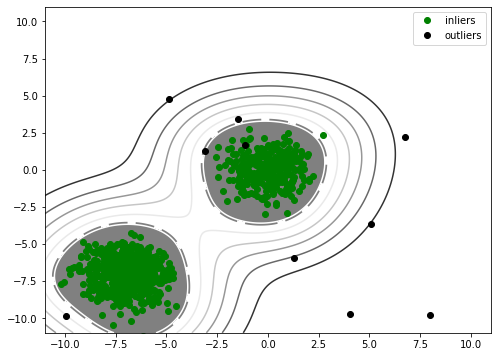

In [15]:
scores_pred = classifier.decision_function(x)
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_ratio)
xx, yy = np.meshgrid(np.linspace(-11,11,1000), np.linspace(-11,11,1000))
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

inlier_plot = plt.plot(x[:num_inliers,0], x[:num_inliers,1], 'go', label='inliers')
outlier_plot = plt.plot(x[-num_outliers:,0], x[-num_outliers:,1], 'ko', label='outliers')

plt.contour(xx, yy, Z, levels=[threshold],linewidths=5, colors='gray')
plt.contour(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Greys_r)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='gray')

plt.xlim(-11,11)
plt.ylim(-11,11)
plt.legend(numpoints=1)
plt.show()

#### Decision boundary for one-class SVM on bimodal synthetic data—trained using only inliers

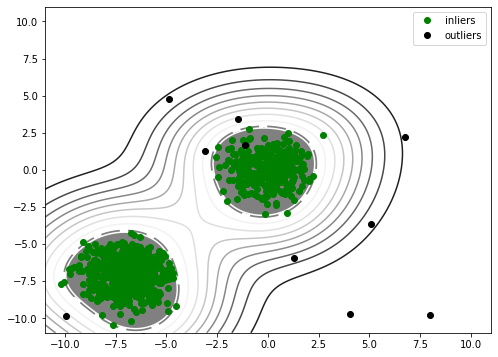

In [16]:
x = np.r_[x_0, x_1, x_2]
classifier = svm.OneClassSVM(nu=0.99 * outlier_ratio + 0.01, kernel="rbf", gamma=0.1)
classifier.fit(x)

scores_pred = classifier.decision_function(x)
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_ratio)
xx, yy = np.meshgrid(np.linspace(-11,11,1000), np.linspace(-11,11,1000))
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

x = np.r_[x, x_rand]

inlier_plot = plt.plot(x[:num_inliers,0], x[:num_inliers,1], 'go', label='inliers')
outlier_plot = plt.plot(x[-num_outliers:,0], x[-num_outliers:,1], 'ko', label='outliers')

plt.contour(xx, yy, Z, levels=[threshold],linewidths=5, colors='gray')
plt.contour(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10), cmap=plt.cm.Greys_r)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='gray')

plt.xlim(-11,11)
plt.ylim(-11,11)
plt.legend(numpoints=1)
plt.show()

## Isolation forest

In [17]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
%matplotlib inline

In [18]:
plt.rcParams["figure.figsize"] = (8,6)

In [19]:
num_dimensions = 2
num_samples = 1000
outlier_ratio = 0.01
num_inliers = int(num_samples * (1-outlier_ratio))
num_outliers = num_samples - num_inliers

In [20]:
x_0 = np.random.randn(num_inliers//3, num_dimensions) - 3
x_1 = np.random.randn(num_inliers//3, num_dimensions)
x_2 = np.random.randn(num_inliers//3, num_dimensions) + 4

# Add outliers sampled from a random uniform distribution
x = np.r_[x_0, x_1, x_2, np.random.uniform(low=-10, high=10, size=(num_outliers, num_dimensions))]

# Generate labels, 1 for inliers and -1 for outliers
labels = np.ones(num_samples, dtype=int)
labels[-num_outliers:] = -1

### `IsolationForest()`

/Users/Tin/projects/ml_security/venv2/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/Tin/projects/ml_security/venv2/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Number of errors: 10


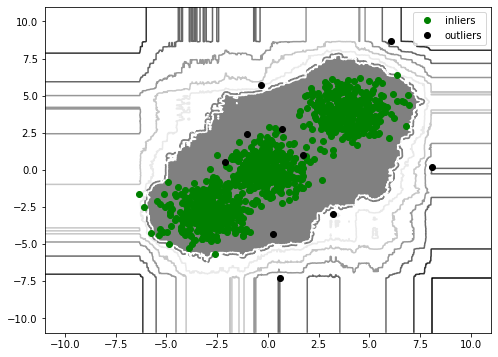

In [21]:
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(99)

classifier = IsolationForest(max_samples=num_samples, contamination=outlier_ratio, random_state=rng)
classifier.fit(x)
y_pred = classifier.predict(x)
num_errors = sum(y_pred != labels)
print('Number of errors: {}'.format(num_errors))

scores_pred = classifier.decision_function(x)
threshold = stats.scoreatpercentile(scores_pred, 100 * outlier_ratio)
xx, yy = np.meshgrid(np.linspace(-11,11,1000), np.linspace(-11,11,1000))
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

inlier_plot = plt.plot(x[:num_inliers,0], x[:num_inliers,1], 'go', label='inliers')
outlier_plot = plt.plot(x[-num_outliers:,0], x[-num_outliers:,1], 'ko', label='outliers')

plt.contour(xx, yy, Z, levels=[threshold],linewidths=5, colors='gray')
plt.contour(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7), cmap=plt.cm.Greys_r)
plt.contourf(xx, yy, Z, levels=[threshold, Z.max()], colors='gray')

plt.xlim(-11,11)
plt.ylim(-11,11)
plt.legend(numpoints=1)
plt.show()

# Adversarial Machine Learning

## BEISPIEL: Binary Classifier Poisoning Attack

In [4]:
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")
%matplotlib inline

### 1. `Multilayer Perceptron` setzen (MLP)

In [5]:
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0, weights=[.5, .5], random_state=17)
clf = MLPClassifier(max_iter=600, random_state=123).fit(X[:100], y[:100])

### 2. Zweidimensionales Gitter von Punkten im Eingaberaum `X`, `Y`

In [6]:
xx, yy = np.mgrid[-3:3:.01, -3:3:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

### 3. Konturdiagramm erzeugen und Test set plotten

[(-3, 3), (-3, 3), None]

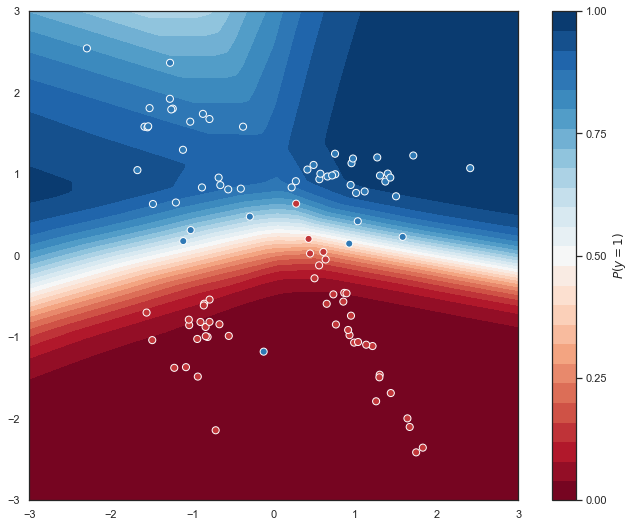

In [7]:
f, ax = plt.subplots(figsize=(12, 9))
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)

ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)

ax.set(aspect="equal", xlim=(-3, 3), ylim=(-3, 3))

### 4. Original MLP Classifier Decision Boundary

In [8]:
def plot_decision_boundary(X_orig, y_orig, probs_orig, chaff_X=None, chaff_y=None, probs_poisoned=None):
    f, ax = plt.subplots(figsize=(12, 9))

    ax.scatter(X_orig[100:,0], X_orig[100:, 1], 
               c=y_orig[100:], s=50, cmap="gray",
               edgecolor="black", linewidth=1)
    
    if all([(chaff_X is not None),
            (chaff_y is not None),
            (probs_poisoned is not None)]):
        ax.scatter(chaff_X[:,0], chaff_X[:, 1], 
                   c=chaff_y, s=50, cmap="gray", 
                   marker="*", edgecolor="black", linewidth=1)
        ax.contour(xx, yy, probs_orig, levels=[.5], 
                   cmap="gray", vmin=0, vmax=.8)
        ax.contour(xx, yy, probs_poisoned, levels=[.5], 
                   cmap="gray")
    else:
        ax.contour(xx, yy, probs_orig, levels=[.5], cmap="gray")

    ax.set(aspect="equal", xlim=(-3, 3), ylim=(-3, 3))

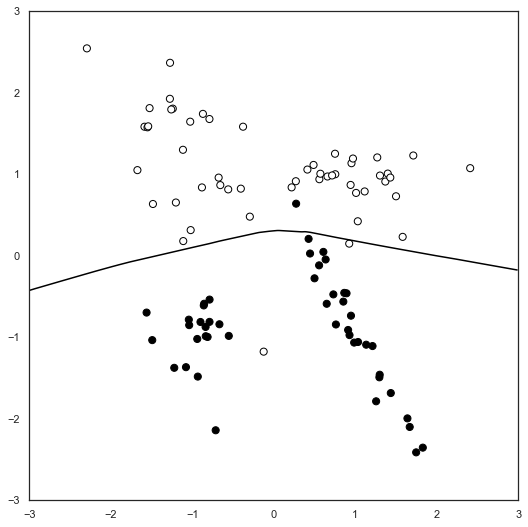

In [9]:
plot_decision_boundary(X, y, probs)

<font color="green"><b>Decision Boundary von MLP klassifiziert auf Datensatz</b></font>

## Poisoning Traffic

Intrusion von 5% Chaff

In [10]:
num_chaff = 5
chaff_X = np.array([np.linspace(-2, -1, num_chaff), np.linspace(0.1, 0.1, num_chaff)]).T
chaff_y = np.ones(num_chaff)

### 1x Anpassen des MLP Classifiers an die 5 Chaffs

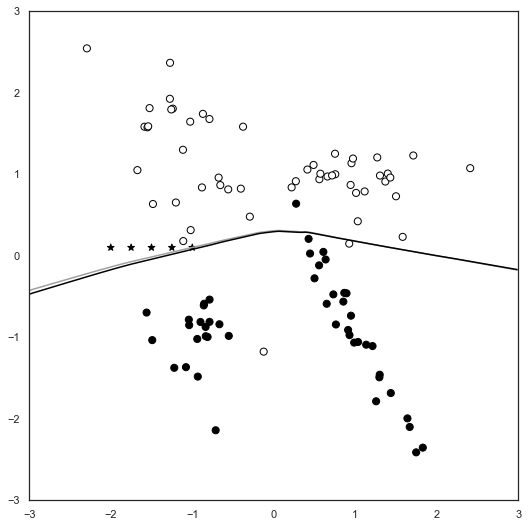

In [11]:
clf.partial_fit(chaff_X, chaff_y)
probs_poisoned = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plot_decision_boundary(X, y, probs, chaff_X, chaff_y, probs_poisoned)

### 2x Anpassen des MLP Classifiers an die 5 Chaffs

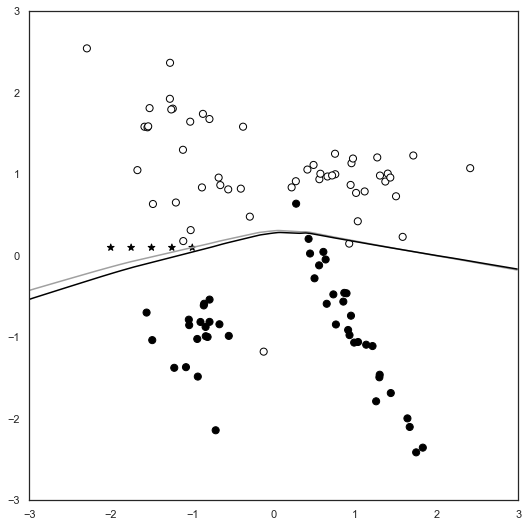

In [12]:
clf.partial_fit(chaff_X, chaff_y)
probs_poisoned = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plot_decision_boundary(X, y, probs, chaff_X, chaff_y, probs_poisoned)

### 3x Anpassen des MLP Classifiers an die 5 Chaffs

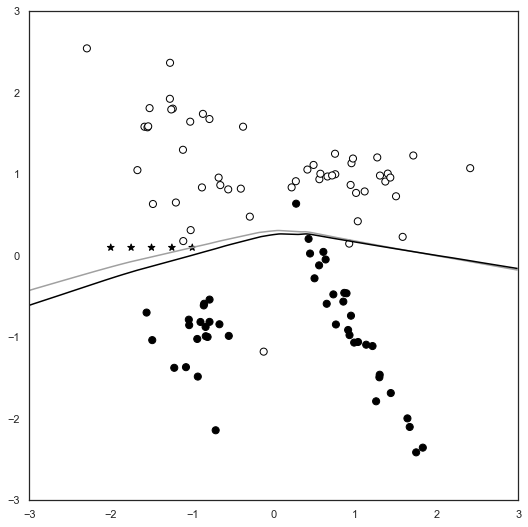

In [13]:
clf.partial_fit(chaff_X, chaff_y)
probs_poisoned = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plot_decision_boundary(X, y, probs, chaff_X, chaff_y, probs_poisoned)

### 4x Anpassen des MLP Classifiers an die 5 Chaffs

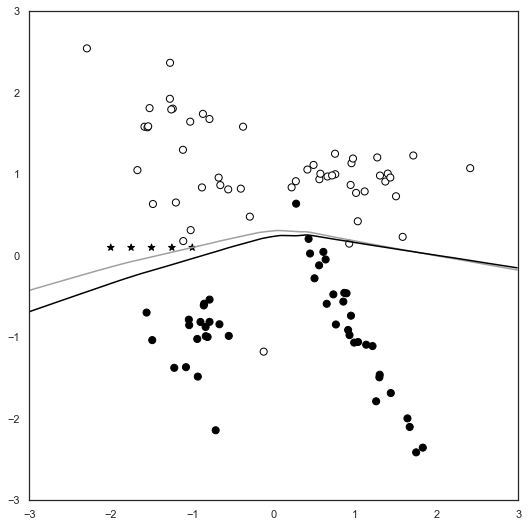

In [14]:
clf.partial_fit(chaff_X, chaff_y)
probs_poisoned = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plot_decision_boundary(X, y, probs, chaff_X, chaff_y, probs_poisoned)

### 5x Anpassen des MLP Classifiers an die 5 Chaffs

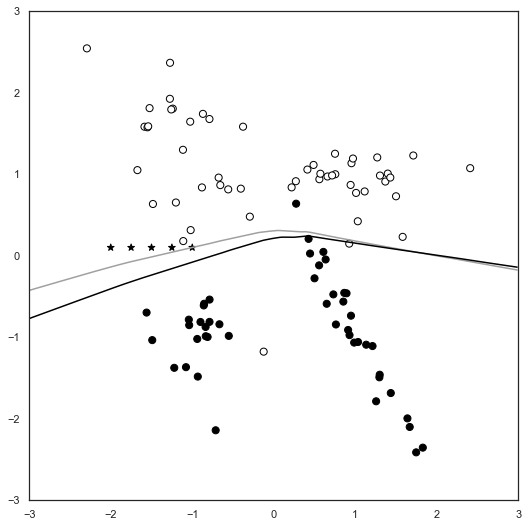

In [15]:
clf.partial_fit(chaff_X, chaff_y)
probs_poisoned = clf.predict_proba(grid)[:, 1].reshape(xx.shape)
plot_decision_boundary(X, y, probs, chaff_X, chaff_y, probs_poisoned)